# HMC

In [1]:
import numpy as np
import pymc3 as pm

import aesara
import aesara.tensor as at
from aesara.tensor.random.utils import RandomStream
from aeppl.transforms import TransformValuesOpt, LogTransform

from aeppl import joint_logprob

import aehmc.hmc as hmc
from aehmc.utils import RaveledParamsMap

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
NUM_INTEGRATION_STEPS = 1024
STEP_SIZE = 5e-5
PATH_LENGTH = STEP_SIZE * NUM_INTEGRATION_STEPS

NUM_SAMPLES = 1_000
BURNIN = 100

## The model: a simple linear regression

We consider a simple one-dimensional regression problem. To make it a little challenging, we create a dataset with 10,000 points:

In [3]:
X_val = np.random.normal(0, 1, size=(10_000,))
y_val = 3 * X_val + np.random.normal(0,1)

### PyMC3 implementation

In [4]:
with pm.Model() as pymc3_model:
    weights = pm.Normal("weights", mu=0, sigma=1)
    noise = pm.Gamma("noise", alpha=2, beta=1)
    y_observed = pm.Normal(
        "y_observed",
        mu=X_val @ weights,
        sigma=noise,
        observed=y_val,
    )

### Aeppl implementation

We can implement the posterior log-probability density function of this model directly using `aesara` and `aeppl`:

In [5]:
X_at = at.as_tensor(X_val)

N_rv = at.random.gamma(2.0, 1.0, name="N")
W_rv = at.random.normal(0, 1.0, name="W")
Y_rv = at.random.normal(X_at.dot(W_rv), N_rv, name="Y")


# `aehmc` kernels take a vector as an input. We use a `RaveledParamsMap` to unravel this vector
# and retrieve ta values for `W_rv` and `Y_rv`.
rp_map = RaveledParamsMap((W_rv, N_rv))


def aeppl_logprob(q):
    uraveled_params = rp_map.unravel_params(q)
    N_vv = uraveled_params[N_rv]
    W_vv = uraveled_params[W_rv]
    
    # The gamma distribution's support is the positive real numbers; algorithms like HMC however prefer to 
    # with parameters on the real line. We thus apply a log transform to `N_vv`. PyMC3 applies this 
    # transform automatically.
    transforms_op = TransformValuesOpt({N_vv: LogTransform()})

    logprob = joint_logprob({Y_rv: at.as_tensor(y_val), N_rv: N_vv, W_rv: W_vv}, extra_rewrites=transforms_op)
    return logprob

In [6]:
q = at.vector('q')
logprob_fn = aesara.function((q,), aeppl_logprob(q))
logprob_fn([3., np.log(10.)])

array(-32227.40345271)

We can check that the loglikelihood returns the same values as the logpdf produced by PyMC3:

In [7]:
pymc3_model.fastlogp({'weights':3, 'noise_log__': np.log(10)})

array(-32227.40345271)

## Sampling with aehmc

### Build the HMC kernel

The `hmc.kernel` function returns, given the parameters of the HMC algorithm (a random seed, the potential, the step size, inverse mass matrix and number of integration steps) returns a "kernel" which given a chain state returns a graph that computes the next chain state:

In [8]:
srng = RandomStream(seed=1)
inverse_mass_matrix = at.as_tensor(np.array([1., 1.]))
kernel = hmc.kernel(srng, aeppl_logprob, inverse_mass_matrix, NUM_INTEGRATION_STEPS)

Let us compile this graph into a function:

In [9]:
q = at.vector("q")
potential_energy = -aeppl_logprob(q)
potential_energy_grad = aesara.grad(potential_energy, wrt=q)

next_step = kernel(q, potential_energy, potential_energy_grad, STEP_SIZE)
kernel_fn = aesara.function((q,), next_step)

Let's execute it for one position:

In [10]:
kernel_fn(np.array([3., np.log(.21)]))

[array([ 2.99274555, -1.63415715]),
 array(-3584.58957814),
 array([-1445.72009142,  2880.72321044]),
 array(1.)]

### Build the trajectory

We can also build a graph that computes the entire trajectory given the initial position and a number of samples, using aesara `scan` construct:

In [11]:
def build_trajectory_generator(srng, kernel_generator, logprob_fn, num_samples):
    """Builds a function which, given an initial position, returns the full trajectory."""
    q = at.vector("q")
    potential_energy = -logprob_fn(q)
    potential_energy_grad = aesara.grad(potential_energy, wrt=q)

    step_size = at.scalar("step_size")
    inverse_mass_matrix = at.vector("inverse_mass_matrix")
    num_integration_steps = at.scalar("num_integration_steps", dtype="int32")

    kernel = kernel_generator(
        srng, logprob_fn, inverse_mass_matrix, num_integration_steps
    )

    trajectory, updates = aesara.scan(
        fn=kernel,
        outputs_info=[
            {"initial": q},
            {"initial": potential_energy},
            {"initial": potential_energy_grad},
            None,
        ],
        non_sequences=step_size,
        n_steps=num_samples,
    )
    trajectory_generator = aesara.function(
        (q, step_size, inverse_mass_matrix, num_integration_steps),
        trajectory,
        updates=updates,
        mode='FAST_RUN'
    )

    return trajectory_generator

We can now compile the function that generates the chain and execute it:

In [12]:
%%time
trajectory_generator = build_trajectory_generator(
    srng, hmc.kernel, aeppl_logprob, num_samples=NUM_SAMPLES
)

initial_position = np.array([3., np.log(0.6)])
inverse_mass_matrix = np.array([1., 1.])
position, *_ = trajectory_generator(initial_position, STEP_SIZE, inverse_mass_matrix, NUM_INTEGRATION_STEPS)

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (TensorConstant{1},), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 894, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2837, in get_vector_length
    raise ValueError

WARNING (aesara.tensor.basic_opt): Failed to infer_shape from Op normal_rv{0, (0, 0), floatX, False}.
Input shapes: [None, (Shape_i{0}.0,), (), (), ()]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Length of <TensorType(int64, vector)> cannot be determined
Traceback: Traceback (most recent call last):
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 894, in get_node_infer_shape
    o_shapes = shape_infer(
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 299, in infer_shape
    shape = self._infer_shape(size, dist_params, param_shapes=param_shapes)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/random/op.py", line 183, in _infer_shape
    size_len = get_vector_length(size)
  File "/home/remi/.virtualenvs/aehmc/lib/python3.9/site-packages/aesara/tensor/basic.py", line 2837, in get_vector_length
    raise ValueError(f"Le

CPU times: user 48.8 s, sys: 42.7 ms, total: 48.9 s
Wall time: 49.3 s


Let us quickly check that the chain sampled correctly:

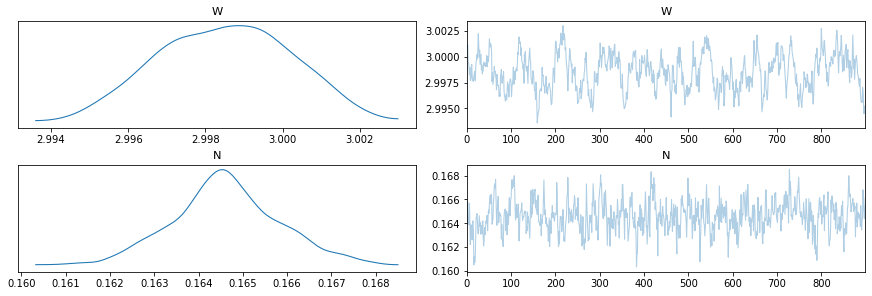

In [13]:
import arviz as az

aehmc_trace = az.from_dict(posterior={"W": position[BURNIN:, 0], "N": np.exp(position[BURNIN:, 1])})
az.plot_trace(aehmc_trace);

## Sampling with PyMC3

We are now ready to compare the performance of `aehmc`'s HMC kernel to that of PyMC3.

In [14]:
import time 

with pymc3_model:
    step = pm.step_methods.hmc.hmc.HamiltonianMC(
        [weights, noise],
        path_length=PATH_LENGTH,
        step_scale=STEP_SIZE,
        adapt_step_size=False,
    )
    
    # Set initial values
    weights.tag.test_value = initial_position[0]
    noise.tag.test_value = initial_position[1]
    
with pymc3_model:
    start = time.perf_counter()
    posterior = pm.sample(
        tune=0,
        draws=NUM_SAMPLES,
        step=[step],
        chains=1,
        cores=1,
        return_inferencedata=False,
        compute_convergence_checks=False
    )
    end = time.perf_counter()
    print(end - start)

Sequential sampling (1 chains in 1 job)
HamiltonianMC: [noise, weights]


Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 86 seconds.
The acceptance probability does not match the target. It is 0.999966678301214, but should be close to 0.65. Try to increase the number of tuning steps.


86.43530971600012


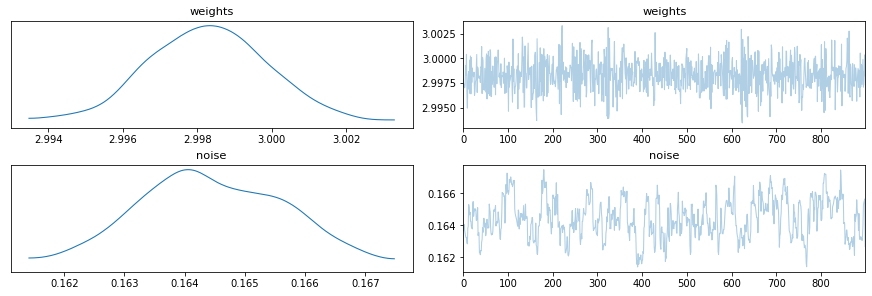

In [15]:
posterior_trace = az.from_pymc3(posterior[BURNIN:], model=pymc3_model)
az.plot_trace(posterior_trace);